In [143]:
import re
import os
import pathlib
import json

import plotnine
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

In [144]:
experiment = "02_http_constant_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()
results_dir


PosixPath('/home/richard/projects/mesh-bench/results/02_http_constant_throughput')

In [145]:
"""
Clean the obtained results from the experiments
- Remove unnecessary columns
- Extract metadata from filenames
- Construct and clean data into a pandas.Series object
- Convert data measures in seconds to ms
"""

# Filter columns
required_cols = [
    "StartTime",
    "RequestedQPS",
    "ActualQPS",
    "DurationHistogram",
]


# fortio reports in seconds, convert to miliseconds
multiplier = 1000


# Regex to extract metadata
# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

"""
Reads a fortio results JSON file, cleans the data and returns
it as a pandas.Series
"""
def clean_fortio_results(results_file: pathlib.Path) -> pd.Series :
    # Read the JSON file as pandas series
    s = pd.read_json(results_file, typ="series")

    # Filter unnecesary columns
    s = s[required_cols]

    # Extract metadata from filename and add it to the series
    matches = re.match(name_re, str(results_file.name))
    s["mesh"] = matches[2]
    s["payload"] = matches[4]

    # Extract nested columns in 'DurationHistogram'
    for key, val in s["DurationHistogram"].items():
        s[key] = val
    s = s.drop(["DurationHistogram", "Percentiles"])

    # Convert obervations from seconds to miliseconds
    s.loc[["Min", "Max", "Sum", "Avg"]] *= multiplier

    # Construct Histogram Bins, Counts and Percentiles
    data = s["Data"]

    s["counts"] = [x["Count"] for x in data]
    s["percentages"] = [x["Percent"] for x in data]

    # Bins (default pd.cut function makes them as categoricals of intervals)
    # https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
    # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
    s["categories"]= pd.Categorical([pd.Interval(x["Start"] * multiplier , x["End"] * multiplier) for x in data])
    s["bins"] = [x.left for x in s["categories"]]
    s["bins"].append(s["categories"][-1].right)

    s = s.drop("Data")

    return s


In [146]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""

# Regex to extra# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")


series = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Extract metadata from the result
        matches = re.match(name_re, file)

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        series.append(clean_fortio_results(p))

df = pd.DataFrame(series)

# Re-order
df = df[[
    "mesh",
    "RequestedQPS",
    "payload",
    "ActualQPS",
    "StartTime",
    "Count",
    "Min",
    "Max",
    "Sum",
    "Avg",
    "StdDev",
    "counts",
    "percentages",
    "categories",
    "bins",
]]

# Sort
df = df.sort_values(by=["mesh", "RequestedQPS", "payload"], ignore_index=True)
df.head()

Parsing Experiment results:
Exp: 02_http_constant_throughput
Results: 20


,mesh,RequestedQPS,payload,ActualQPS,StartTime,Count,Min,Max,Sum,Avg,StdDev,counts,percentages,categories,bins
0,baseline,1,0,0.966558,2022-06-20T08:47:59.706739895Z,896,0.303539,74.825911,1030.766387,1.150409,0.002706,"[23, 4, 7, 48, 73, 151, 197, 191, 101, 63, 9, ...","[2.566964285714285, 3.013392857142857, 3.79464...","[(0.303539, 0.4], (0.4, 0.5], (0.5, 0.60000000...","[0.303539, 0.4, 0.5, 0.6000000000000001, 0.7, ..."
1,baseline,100,0,99.965399,2022-06-20T09:03:26.943572434Z,89984,0.154036,134.294973,41243.842089,0.458346,0.002610,"[79, 37925, 44872, 4633, 633, 237, 150, 111, 1...","[0.08779338549075301, 42.234174964438125, 92.1...","[(0.154036, 0.2], (0.2, 0.30000000000000004], ...","[0.154036, 0.2, 0.30000000000000004, 0.4, 0.5,..."
2,baseline,1000,0,996.363930,2022-06-20T09:41:33.911050747Z,896759,0.066993,117.589328,269135.784729,0.300121,0.001880,"[671, 630774, 213930, 18537, 6312, 4045, 2703,...","[0.074825008725867, 70.41412464218368, 94.2700...","[(0.066993, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.066993, 0.1, 0.2, 0.30000000000000004, 0.4,..."
3,baseline,500,0,499.102065,2022-06-20T09:18:27.311672176Z,449207,0.094078,125.927181,159324.945349,0.354680,0.002462,"[7, 171510, 249086, 14288, 2941, 1411, 867, 61...","[0.001558301629315, 38.18217436504774, 93.6323...","[(0.09407800000000001, 0.1], (0.1, 0.2], (0.2,...","[0.09407800000000001, 0.1, 0.2, 0.300000000000..."
4,cilium,1,0,0.966557,2022-06-20T18:37:27.091705475Z,896,0.327164,80.603272,1481.862383,1.653864,0.003155,"[5, 10, 10, 4, 2, 1, 10, 26, 38, 298, 317, 95,...","[0.5580357142857141, 1.674107142857142, 2.7901...","[(0.327164, 0.4], (0.4, 0.5], (0.5, 0.60000000...","[0.327164, 0.4, 0.5, 0.6000000000000001, 0.7, ..."


In [147]:
"""
Plotting of the results
- Create grid of subplots
- Plot figures on logarithmic scale (because of outliers)
- Plot Constant Throughput per mesh
"""


def create_constant_throughput_figure(mesh: str, color: str) -> plt.figure:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    # Set figure title
    fig.suptitle(f"HTTP Constant Throughput - $\\bf{mesh.capitalize()}$", fontsize=18, y=1)

    # Subset the dataframe to only contains rows of the mesh
    data = df[df["mesh"] == mesh]

    # Plot each row as subplot
    for i ,(_, row) in enumerate(data.iterrows()):
        ax = axes[i]

        # Plot data
        binedges = np.array(row["bins"])
        weights = np.array(row["counts"])
        x = (binedges[1:] + binedges[:-1]) / 2.0

        sns.histplot(data=row, x=x, bins=binedges, weights=weights, color="b", ax=ax)

        # Labels
        plot_title = (
            f"RPS: {row['RequestedQPS']}\n"
            f"min: {row['Min']:.1f} ms, avg: {row['Avg']:.1f} ms, max: {row['Max']:.1f} ms"
        )
        ax.set_ylabel("Request Count")
        ax.set_xlabel("Latency in ms")
        ax.set_title(plot_title, y=1.05)


        # Y AXIS
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())


        # X AXIS
        ax.set_xscale("log")
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())


        # # Second plot with cumulative density
        ax2 = ax.twinx()
        ax2.set_alpha(0.5)
        ax2.grid(False)
        sns.ecdfplot(data=row, x=x, weights=weights, color="orange", ax=ax2)

    fig.tight_layout()
    return fig

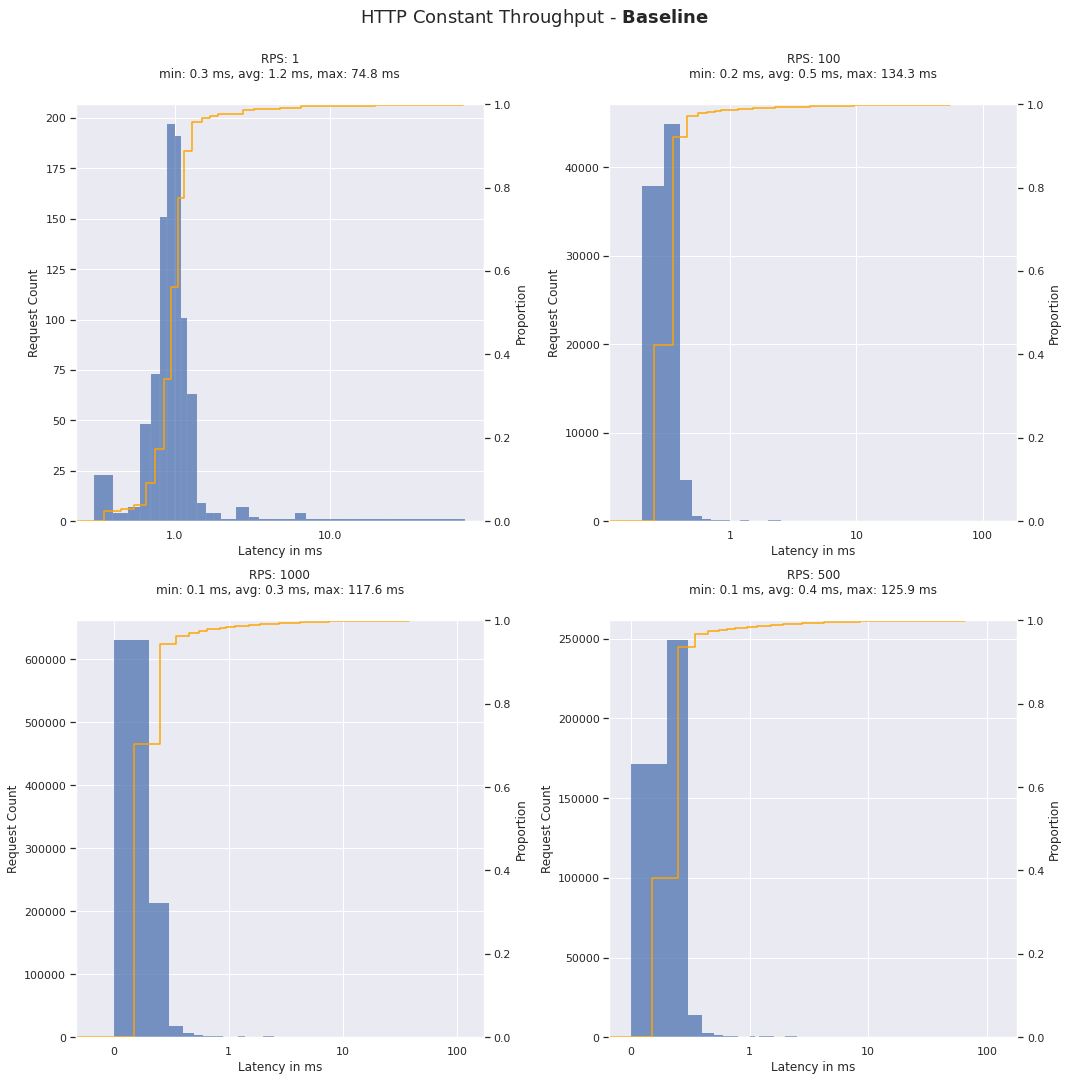

In [148]:
fig = create_constant_throughput_figure("baseline", "b")
fig.show()

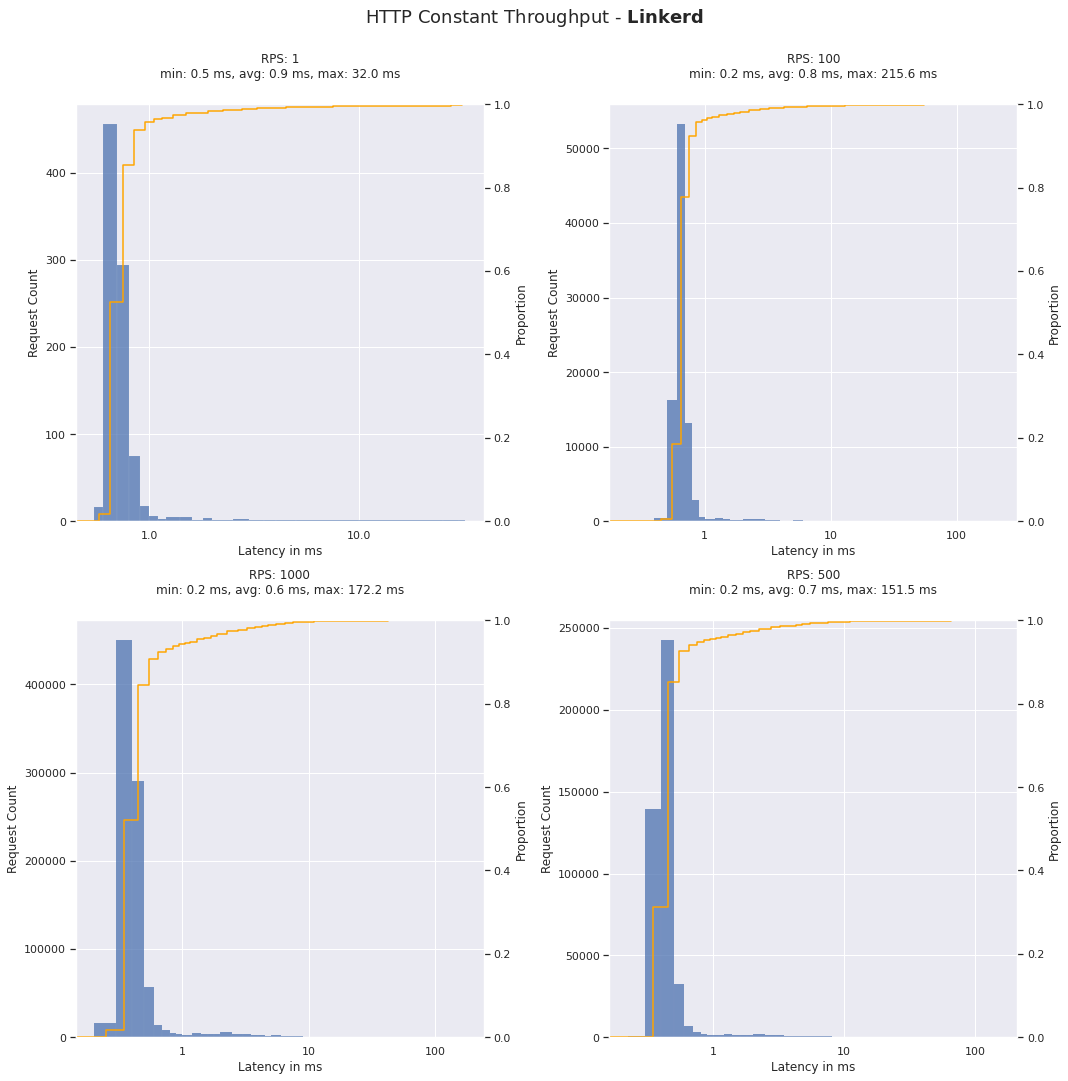

In [149]:
fig = create_constant_throughput_figure("linkerd", "b")
fig.show()

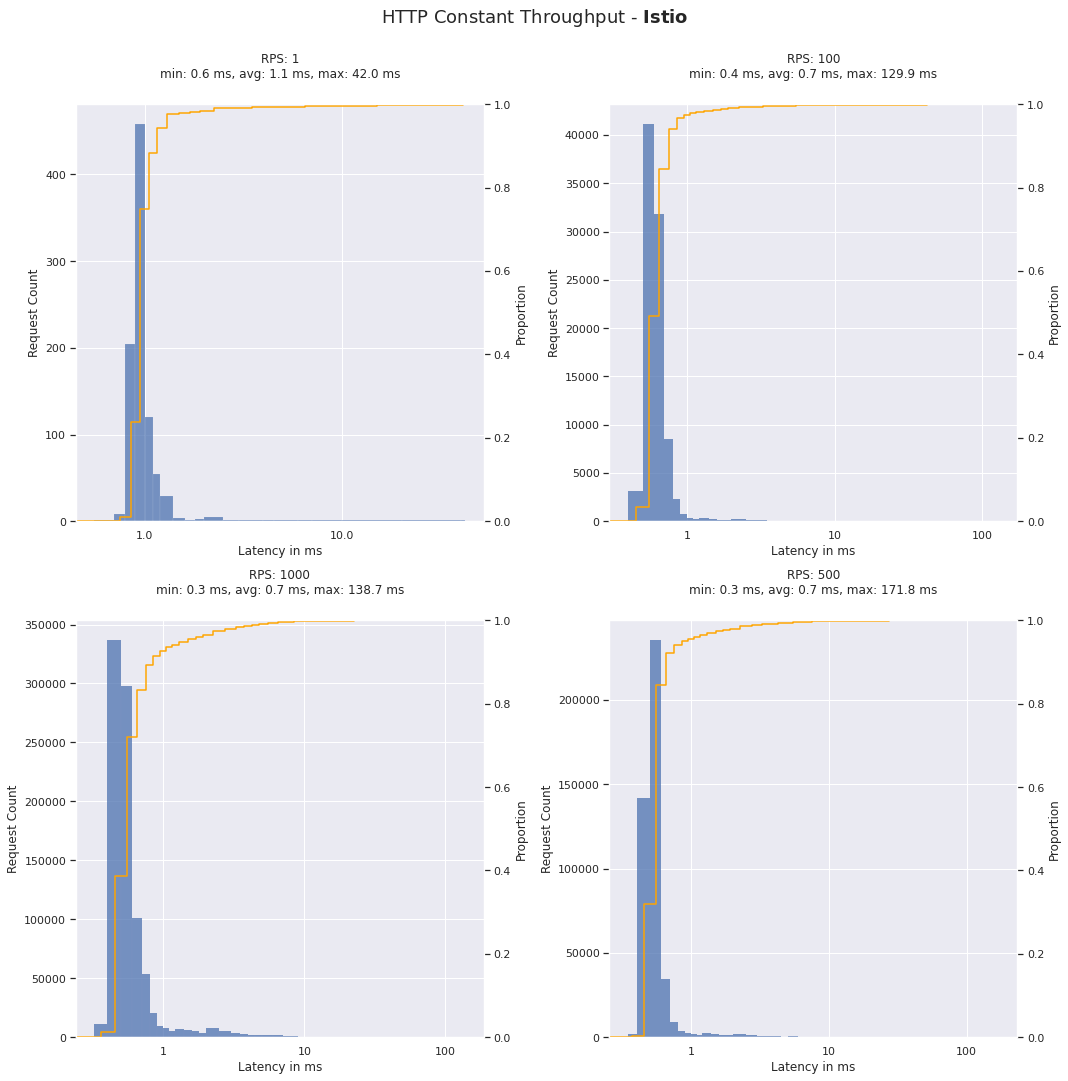

In [150]:

fig = create_constant_throughput_figure("istio", "b")
fig.show()

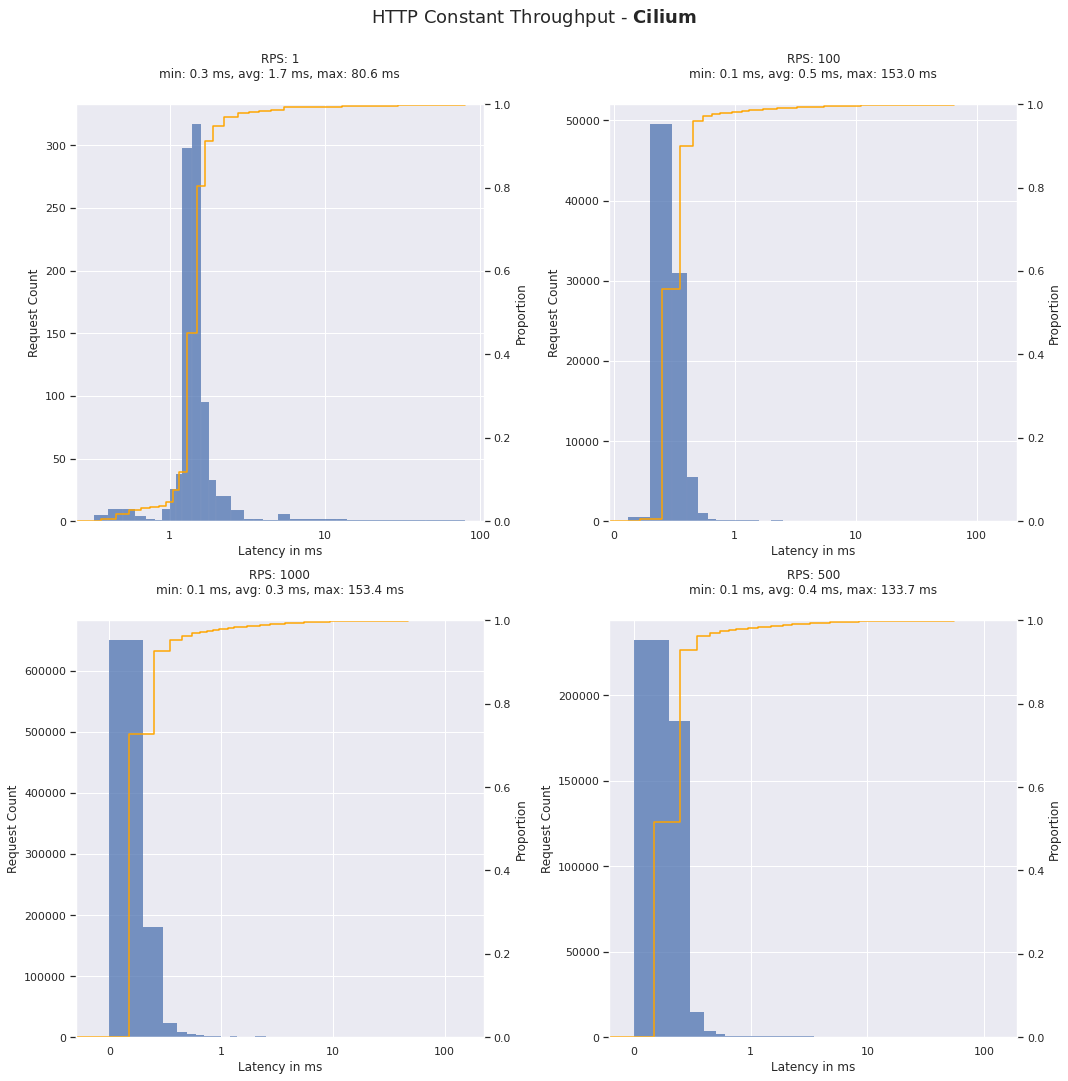

In [151]:

fig = create_constant_throughput_figure("cilium", "b")
fig.show()

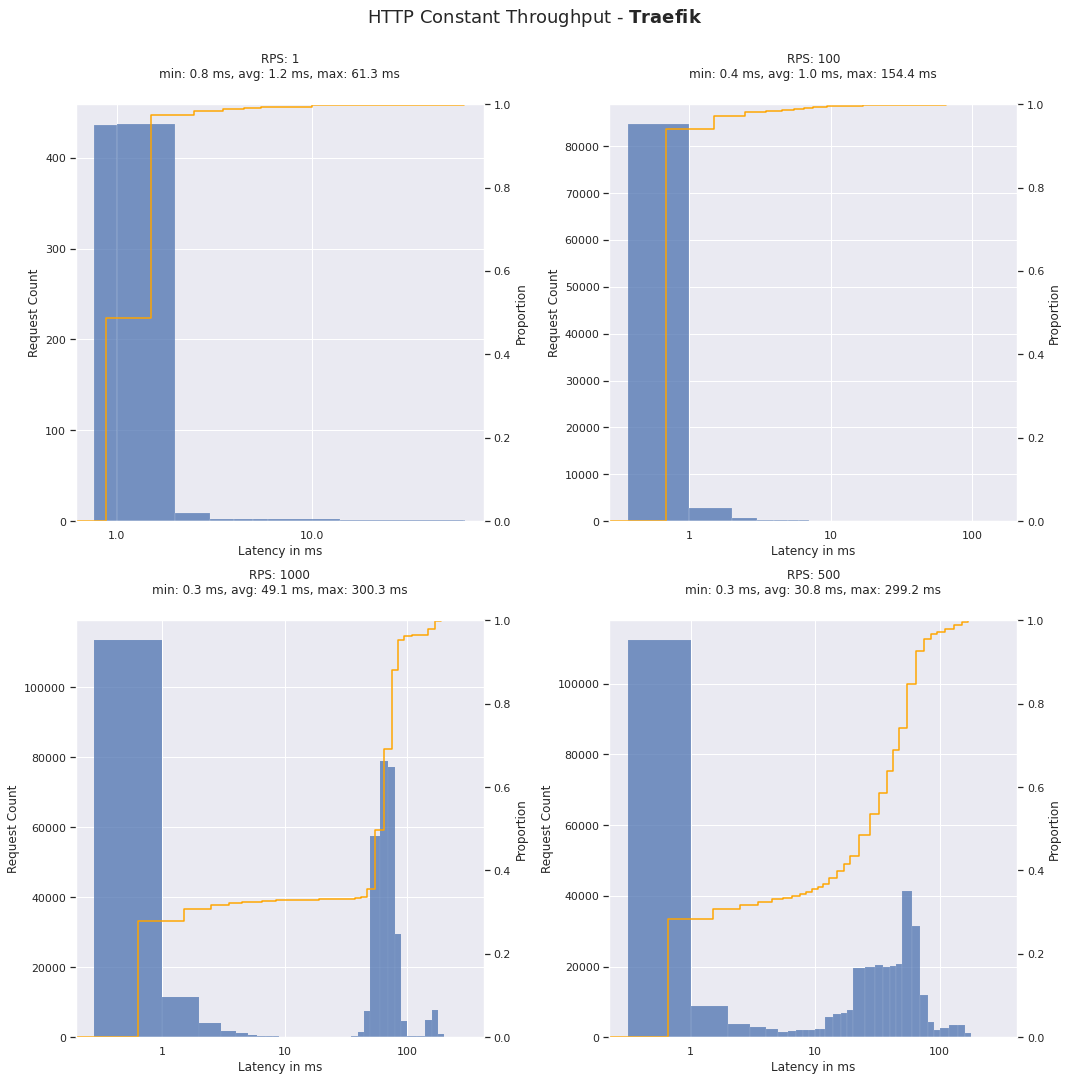

In [152]:

fig = create_constant_throughput_figure("traefik", "b")
fig.show()